# Optimization frp 9x9 Sudoku
As disussed in Chapter 02 we will now extend our Sudoku - Puzzle from 4x4 to 9x9.
We will check whether the puzzle is solved per:
- `entropy_mean` which should converge to 0
- `check_grid`which checks if the Sudoku Rules are fullfilled

All needed functions are defined in `/source`

## 1.0 Initialization of 9x9 Grid
- we have our puzzle which creates our Optimizer Tensor Z
- Z will be hand over to 

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.set_printoptions(precision=4, sci_mode=False)
device = torch.device("cuda")

from source import probs_from_logits, pretty_grid_from_probs, optimize_sudoku, loss_dict, print_losses, check_grid
from source import entropy_mean

dim = 9
grid = torch.tensor([
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],

    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],

    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9],
], dtype=torch.long)

# Build givens mask + targets (targets are digit-1 in [0..3])
givens_mask = grid != 0
givens_target = (grid-1).clamp(min=0)

Z = torch.zeros((dim,dim,dim), dtype=torch.float32, device=device)

# Strongly bias given cells (large positive logit for the correct digit, negative for others)
high = 6.0
low = -6.0
for r in range(dim):
    for c in range(dim):
        if givens_mask[r,c]:
            k = int(givens_target[r,c].item())  # 0..3
            Z[r,c,:] = low
            Z[r,c,k] = high


grid, givens_mask, givens_target, Z

(tensor([[5, 3, 0, 0, 7, 0, 0, 0, 0],
         [6, 0, 0, 1, 9, 5, 0, 0, 0],
         [0, 9, 8, 0, 0, 0, 0, 6, 0],
         [8, 0, 0, 0, 6, 0, 0, 0, 3],
         [4, 0, 0, 8, 0, 3, 0, 0, 1],
         [7, 0, 0, 0, 2, 0, 0, 0, 6],
         [0, 6, 0, 0, 0, 0, 2, 8, 0],
         [0, 0, 0, 4, 1, 9, 0, 0, 5],
         [0, 0, 0, 0, 8, 0, 0, 7, 9]]),
 tensor([[ True,  True, False, False,  True, False, False, False, False],
         [ True, False, False,  True,  True,  True, False, False, False],
         [False,  True,  True, False, False, False, False,  True, False],
         [ True, False, False, False,  True, False, False, False,  True],
         [ True, False, False,  True, False,  True, False, False,  True],
         [ True, False, False, False,  True, False, False, False,  True],
         [False,  True, False, False, False, False,  True,  True, False],
         [False, False, False,  True,  True,  True, False, False,  True],
         [False, False, False, False,  True, False, False,  True

**Interpretation**  
All needed input variables (Z, givens_mask and givens_target) for ADAM are defined 

# 2.0 Start Optimization 
Now we start the ADAM Optimizer with needed parameters as:
- Iteration steps
- T_start
- T_end
- lr (learning rate)
- block_size 3

At the end we will output some Graphs which shows that the loss function converges to 0

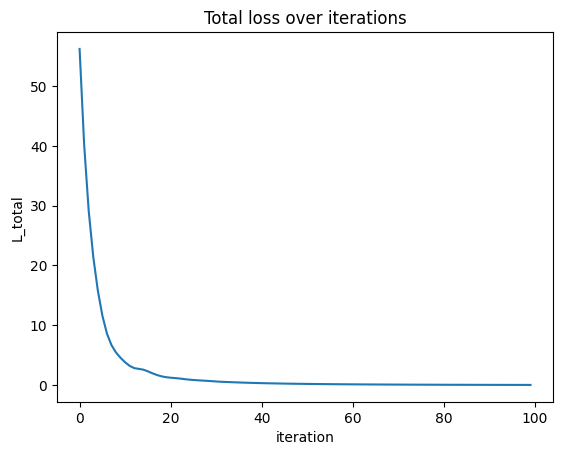

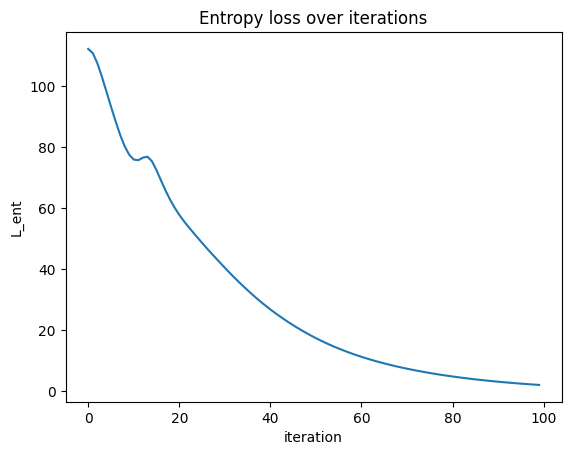

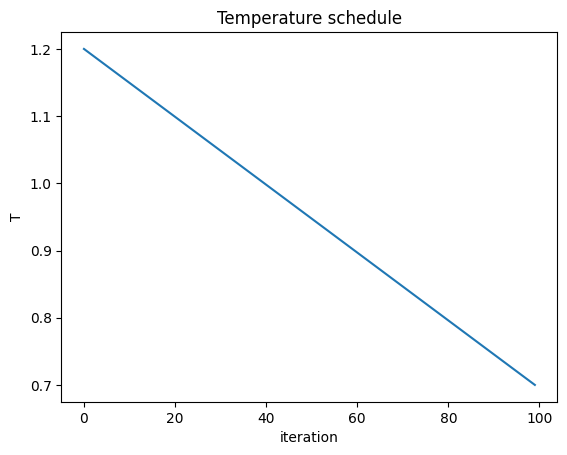

In [6]:
T_start = 1.2
T_end = 0.7
lr = 0.3
block_size = 3

Z_final, hist = optimize_sudoku(
    Z, givens_mask, givens_target,
    steps=100,
    lr=lr,
    T_start=T_start,
    T_end=T_end,
    block_size=block_size,
    w_row=1.0,
    w_col=1.0,
    w_blk=1.2,
    w_giv=2.0,
    w_ent=0.01,
    save_P_every=10,
)

P_final = probs_from_logits(Z_final, T=T_end)

plt.figure()
plt.plot(hist["L_total"])
plt.title("Total loss over iterations")
plt.xlabel("iteration")
plt.ylabel("L_total")
plt.show()

plt.figure()
plt.plot(hist["L_ent"])
plt.title("Entropy loss over iterations")
plt.xlabel("iteration")
plt.ylabel("L_ent")
plt.show()

plt.figure()
plt.plot(hist["T"])
plt.title("Temperature schedule")
plt.xlabel("iteration")
plt.ylabel("T")
plt.show()


**Interpretation**  
We observe that the total_loss diverges to 0 at step = 20.
But we do not know if the solution at step = 20 is correct or not.

Let's take a closer look to this by checking every 10th step

In [7]:
for step, P in hist["P_snapshots"].items():
    mean_entropy = entropy_mean(P)
    #ent = -(P * (P + 1e-9).log()).sum(dim=2)   # (9,9)
    print(step, "mean_entropy=", mean_entropy)
    check_grid(P)
    conf = P.max(dim=2).values                 # (9,9)
    print(step, "mean_maxP=", conf.mean().item(), "min_maxP=", conf.min().item())
    print("---------------------------------------\n")



0 mean_entropy= 1.38491690158844
tensor([[5, 3, 1, 1, 7, 1, 1, 1, 1],
        [6, 1, 1, 1, 9, 5, 1, 1, 1],
        [1, 9, 8, 1, 1, 1, 1, 6, 1],
        [8, 1, 1, 1, 6, 1, 1, 1, 3],
        [4, 1, 1, 8, 1, 3, 1, 1, 1],
        [7, 1, 1, 1, 2, 1, 1, 1, 6],
        [1, 6, 1, 1, 1, 1, 2, 8, 1],
        [1, 1, 1, 4, 1, 9, 1, 1, 5],
        [1, 1, 1, 1, 8, 1, 1, 7, 9]])
rows ok: False cols ok: False blocks ok: False
0 mean_maxP= 0.4401947855949402 min_maxP= 0.1111111119389534
---------------------------------------

10 mean_entropy= 0.9372321963310242
tensor([[5, 3, 1, 6, 7, 8, 9, 9, 8],
        [6, 4, 7, 1, 9, 5, 3, 3, 8],
        [1, 9, 8, 3, 4, 8, 5, 6, 7],
        [8, 1, 9, 7, 6, 1, 7, 2, 3],
        [4, 2, 6, 8, 5, 3, 7, 2, 1],
        [7, 1, 3, 9, 2, 1, 8, 4, 6],
        [9, 6, 9, 7, 3, 7, 2, 8, 4],
        [2, 8, 7, 4, 1, 9, 6, 3, 5],
        [3, 4, 5, 6, 8, 2, 1, 7, 9]])
rows ok: False cols ok: False blocks ok: False
10 mean_maxP= 0.6424571871757507 min_maxP= 0.30438193678855896
----